<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/Merton_Calibration_Numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The **Merton (M76)** jump-diffusion model incorporates both volatility and jumps in the underlying asset price.

The code aims to calibrate the Merton model parameters (λ,μ,δ,v)
by minimizing the squared differences between the model and market option prices.

The model was initially calibrated in batches of implied volatility ranges because of the computational resources demanded by the structure of the code. Perhaps I should have used numba before processing the calibrations in batches.

Given the Merton (M76) model's characteristic function:

$Phi_T(u) = \exp \left( \left( i u \omega + \lambda \left( \exp \left( i u \mu - u^2 \frac{\delta^2}{2} \right) - 1 \right) \right) T \right)
$

where
$omega = r - \frac{1}{2} \sigma^2 - \lambda \left( \exp \left( \mu + \frac{\delta^2}{2} \right) - 1 \right) $,

and where $ \omega $ is a drift correction for the jump component, given by:

$
\omega = -\lambda \left( \exp(\mu + 0.5 \delta^2) - 1 \right)
$

the call option price can be calculated as:

$
C_0 = \max \left( 0, S_0 - e^{-rT} \sqrt{\frac{S_0 K}{\pi}} \times \int_0^\infty \frac{\exp \left( i u \ln \left( \frac{S_0}{K} \right) \right) \Phi_T(u - \frac{i}{2})}{u^2 + 0.25} \, du \right)
$

**Understanding of Topics and Tools Demonstrated in the Code**

1. **Imported Libraries**:
   - `pandas` and `numpy` are fundamental packages for data manipulation and mathematical operations, respectively.
   - `quad` from `scipy.integrate` is used for numerical integration.
   - `minimize` from `scipy.optimize` is used for optimization tasks, specifically for calibration in this case.

2. **Merton (M76) Model Functions**:
   - `M76_char_func`: Defines the characteristic function for the Merton model.
   - `M76_char_func_sa`: Defines the characteristic function with stochastic and jump terms.
   - `M76_int_func_sa`: Defines the integration function used for option pricing.
   - `M76_call_value`: Computes the option price using the Merton model.

3. **Calibration**:
   - `objective`: Defines the objective function to be minimized during calibration. This function computes the sum of squared errors between market and model prices.
   - `process_batch`: This function reads the options data, selects a subset of options based on a given implied volatility range, and then calibrates the Merton model separately for CALL and PUT options.

4. **Utility Operations**:
   - Calculation of time to expiration for options.
   - Categorization of options based on implied volatility.

**Strengths**:
1. **Modularity**: The code is modular with well-defined functions for each step.

2. **Flexibility**: The code can handle both call and put option calibrations. The code is designed to handle different implied volatility ranges, making it adaptable to different datasets.

3. **Optimized Calibration**: The calibration process uses the SLSQP (Sequential Least Squares Quadratic Programming) method from SciPy, which is efficient for such optimization problems.

4. **Bounds**: The calibration ensures that the parameters remain within predefined bounds.

**Weaknesses**:
1. **Hardcoded Values**: Some values, such as the risk-free rate `r`, are hardcoded, which might not be accurate for all scenarios.

2. **File Reading**: The function `process_batch` reads the CSV file every time it's called. If this function is called multiple times, it might be inefficient. It would be better to read the file once and pass the data as an argument.

3. **Inefficient Looping**: The code iterates over rows of a DataFrame using iterrows(), which is inefficient for large datasets. Vectorized operations would be more optimal.



In [1]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Extract underlying asset information
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Risk-free rate
r = -0.5  # Example value, you may need to adjust this

#Defining the required functions for the Merton (M76) model
# Valuation of European Call and Put Options
# Under Stochastic Volatility and Jumps
# 09_gmm/BCC_option_valuation.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python

@njit
def M76_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

@njit
def M76_char_func_sa(u, T, r, sigma, lamb, mu, delta):
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

@njit
def M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta):
    char_func_value = M76_char_func_sa(u - 0.5 * 1j, T, r, sigma, lamb, mu, delta)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

def M76_call_value(S0, K, T, r, v0, lamb, mu, delta):
    sigma = np.sqrt(v0)
    int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# Function to price put options using put-call parity
def M76_put_value(C, S0, K, T, r, v0, lamb, mu, delta):
    C = M76_call_value(S0, K, T, r, v0, lamb, mu, delta)
    return C - S0 + K * np.exp(-r * T)

# Define the objective function for the calibration
def objective(params, option_type, options_in_range):
    lamb, mu, delta, v0 = params
    sum_squared_errors = 0
    for idx, row in options_in_range.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = M76_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, v0=v0, lamb=lamb, mu=mu, delta=delta)
            market_price = np.maximum(row['CF_CLOSE'] - row['STRIKE_PRC'], 0) if option_type == 'CALL' else np.maximum(row['STRIKE_PRC'] - row['CF_CLOSE'], 0)
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

# Initial guesses
initial_params = [0.25, -0.2, 0.1, 0.05]  # lamb, mu, delta, v0

# Parameter bounds
bounds = [(0, 1), (-1, 0), (0, 1), (0, 1)]  # Constraints for lamb, mu, delta, v0

# Function to process a batch of options data based on implied volatility range
def process_batch(imp_volt_range):
    # Create a column to categorize options based on the range of implied volatility
    options_data['IMP_VOLT_RANGE'] = options_data['IMP_VOLT'].apply(lambda x: int(x))

    # Select the options in this range
    options_in_range = options_data[options_data['IMP_VOLT_RANGE'] == imp_volt_range]

    # If there are no options in this range, exit the function
    if options_in_range.empty:
        print(f"No options found in implied volatility range {imp_volt_range}")
        return options_in_range, None, None

    # Calibrate for CALL options
    result_call = minimize(lambda x: objective(x, 'CALL', options_in_range), initial_params, bounds=bounds, method='SLSQP')
    lamb_call, mu_call, delta_call, v0_call = result_call.x
    print(f"Calibrated Parameters for CALL options in group {imp_volt_range}:")
    print("Lambda:", lamb_call)
    print("Mu:", mu_call)
    print("Delta:", delta_call)
    print("V0:", v0_call)

    # Calibrate for PUT options
    result_put = minimize(lambda x: objective(x, 'PUT ', options_in_range), initial_params, bounds=bounds, method='SLSQP')  # Notice the space after 'PUT'
    lamb_put, mu_put, delta_put, v0_put = result_put.x
    print(f"Calibrated Parameters for PUT options in group {imp_volt_range}:")
    print("Lambda:", lamb_put)
    print("Mu:", mu_put)
    print("Delta:", delta_put)
    print("V0:", v0_put)

    # Return the DataFrame and calibrated parameters
    return options_in_range, (lamb_call, mu_call, delta_call, v0_call), (lamb_put, mu_put, delta_put, v0_put)

# Example usage: Process the options data for the implied volatility range 23
options_in_range, call_params, put_params = process_batch(23)

# Create a new column for model prices
options_in_range['MODEL_PRICE'] = 0

# Unpack the calibrated parameters
lamb_call, mu_call, delta_call, v0_call = call_params if call_params is not None else (0, 0, 0, 0)
lamb_put, mu_put, delta_put, v0_put = put_params if put_params is not None else (0, 0, 0, 0)

# Price the options using the calibrated parameters
for idx, row in options_in_range.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = M76_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, v0=v0_call, lamb=lamb_call, mu=mu_call, delta=delta_call)
    else: # PUT
      call_price = M76_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, v0=v0_put, lamb=lamb_put, mu=mu_put, delta=delta_put)
      model_price = M76_put_value(call_price, row['CF_CLOSE'], row['STRIKE_PRC'], row['T'], r, v0_put, lamb_put, mu_put, delta_put)
    options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

# Print the options data with the model prices
print(options_in_range)

# Write the DataFrame to a CSV file
options_in_range.to_csv('M76_SLSQP_options_impvolt23_numba.csv', index=False)


Calibrated Parameters for CALL options in group 23:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 23:
Lambda: 0.5694953198563779
Mu: -0.10894921142411318
Delta: 0.5297415839761843
V0: 4.875515057270288e-05


<ipython-input-1-3e2deabee67b>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
1          233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
2          231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
3          235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
4          237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
5          229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
6          239  /GDAX119500F0.EX  2020-05-15  2020-06-19       CALL   
7          227  /GDAX116500F0.EX  2020-05-14  2020-06-19       CALL   
8          232  /GDAX117500R0.EX  2020-04-30  2020-06-19       PUT    
9          230  /GDAX117000R0.EX  2020-04-30  2020-06-19       PUT    
10         234  /GDAX118000R0.EX  2020-05-14  2020-06-19       PUT    
11         236  /GDAX118500R0.EX  2020-05-06  2020-06-19       PUT    
12         241  /GDAX120000F0.EX  2020-05-15  2020-06-19       CALL   
13         225  /GDAX116000F0.EX  2020-05-15  2020-06-19       CALL   
14    

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load the data from the CSV file
data = pd.read_csv('M76_SLSQP_options_impvolt23_numba.csv')

# Calculate the market price for both call and put options
data['MARKET_PRICE'] = 0
data.loc[data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = data.loc[data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
data.loc[data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = data.loc[data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = data[data['PUTCALLIND'] == 'CALL']
put_options = data[data['PUTCALLIND'] == 'PUT ']

# Calculate the MSE for call options
mse_call = mean_squared_error(call_options['MARKET_PRICE'], call_options['MODEL_PRICE'])

# Calculate the MSE for put options
mse_put = mean_squared_error(put_options['MARKET_PRICE'], put_options['MODEL_PRICE'])

mse_call, mse_put


(8.701422539585537e-16, 494222.9122911178)

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate underlying asset information
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Drop rows with missing 'IMP_VOLT' in the options data
options_data = options_data.dropna(subset=['IMP_VOLT'])

# Convert 'IMP_VOLT' to integers
options_data['IMP_VOLT_RANGE'] = options_data['IMP_VOLT'].apply(lambda x: int(x))

# Get all unique implied volatility ranges
imp_volt_ranges = options_data['IMP_VOLT_RANGE'].unique()

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Process all batches
first_iteration = True
for imp_volt_range in imp_volt_ranges:
    options_in_range, call_params, put_params = process_batch(imp_volt_range) # Adjusted here

    # Create a new column for model prices
    options_in_range['MODEL_PRICE'] = 0

    # Unpack the calibrated parameters
    lamb_call, mu_call, delta_call, v0_call = call_params if call_params is not None else (0, 0, 0, 0)
    lamb_put, mu_put, delta_put, v0_put = put_params if put_params is not None else (0, 0, 0, 0)

    # Price the options using the calibrated parameters
    for idx, row in options_in_range.iterrows():
        if row['PUTCALLIND'] == 'CALL':
            model_price = M76_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, v0=v0_call, lamb=lamb_call, mu=mu_call, delta=delta_call)
        else: # PUT
            call_price = M76_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r=r, v0=v0_put, lamb=lamb_put, mu=mu_put, delta=delta_put)
            model_price = M76_put_value(call_price, row['CF_CLOSE'], row['STRIKE_PRC'], row['T'], r, v0_put, lamb_put, mu_put, delta_put)
        options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

    # Print the options data with the model prices
    print(options_in_range)

    # Append DataFrame to the CSV file
    if first_iteration:
        options_in_range.to_csv('M76_SLSQP_options_numba_2.csv', index=False)
        first_iteration = False
    else:
        options_in_range.to_csv('M76_SLSQP_options_numba_2.csv', mode='a', header=False, index=False)


Calibrated Parameters for CALL options in group 23:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 23:
Lambda: 0.5694953198563779
Mu: -0.10894921142411318
Delta: 0.5297415839761843
V0: 4.875515057270288e-05


<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
1          233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
2          231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
3          235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
4          237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
5          229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
6          239  /GDAX119500F0.EX  2020-05-15  2020-06-19       CALL   
7          227  /GDAX116500F0.EX  2020-05-14  2020-06-19       CALL   
8          232  /GDAX117500R0.EX  2020-04-30  2020-06-19       PUT    
9          230  /GDAX117000R0.EX  2020-04-30  2020-06-19       PUT    
10         234  /GDAX118000R0.EX  2020-05-14  2020-06-19       PUT    
11         236  /GDAX118500R0.EX  2020-05-06  2020-06-19       PUT    
12         241  /GDAX120000F0.EX  2020-05-15  2020-06-19       CALL   
13         225  /GDAX116000F0.EX  2020-05-15  2020-06-19       CALL   
14    

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
31         248  /GDAX121500R0.EX  2020-03-12  2020-06-19       PUT    
32         251  /GDAX122500F0.EX  2020-05-15  2020-06-19       CALL   
33         217  /GDAX114000F0.EX  2020-05-15  2020-06-19       CALL   
34         218  /GDAX114000R0.EX  2020-05-14  2020-06-19       PUT    
35         253  /GDAX123000F0.EX  2020-05-14  2020-06-19       CALL   
36         250  /GDAX122000R0.EX  2020-04-06  2020-06-19       PUT    
37         215  /GDAX113500F0.EX  2020-05-15  2020-06-19       CALL   
38         255  /GDAX123500F0.EX  2020-05-11  2020-06-19       CALL   
39         216  /GDAX113500R0.EX  2020-05-15  2020-06-19       PUT    
40         252  /GDAX122500R0.EX  2020-03-11  2020-06-19       PUT    
41         257  /GDAX124000F0.EX  2020-05-15  2020-06-19       CALL   
42         254  /GDAX123000R0.EX  2020-05-15  2020-06-19       PUT    
43         213  /GDAX113000F0.EX  2020-05-15  2020-06-19       CALL   
44    

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for CALL options in group 26:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 26:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 1.8041124150158794e-16
    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
62         205  /GDAX111000F0.EX  2020-05-15  2020-06-19       CALL   
63         206  /GDAX111000R0.EX  2020-05-14  2020-06-19       PUT    
64         271  /GDAX127500F0.EX  2020-05-11  2020-06-19       CALL   
65         266  /GDAX126000R0.EX  2020-05-15  2020-06-19       PUT    
66         273  /GDAX128000F0.EX  2020-05-15  2020-06-19       CALL   
67         268  /GDAX126500R0.EX  2020-05-14  2020-06-19       PUT    
68         203  /GDAX110500F0.EX  2020-05-15  2020-06-19       CALL   
69         204  /GDAX110500R0.EX  2020-05-08  2020-06-19       PUT    
70         275  /GDAX128500F0.EX  2020-05-11  2020-06-19       CALL   
71         270  /GDAX127000R0.EX  2020-05-06  2020-06-19       PUT    
72         201  /GDAX110000F0.EX  2020-05-15  2020-06-19       CALL   
73         202  /GDAX110000R0.EX  202

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for CALL options in group 27:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 27:
Lambda: 0.9999877588735656
Mu: -0.07364112136302337
Delta: 0.9999972670784683
V0: 6.075593258150707e-05
    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
75         279  /GDAX129500F0.EX  2020-05-11  2020-06-19       CALL   
76         272  /GDAX127500R0.EX  2020-03-19  2020-06-19       PUT    
77         199  /GDAX109500F0.EX  2020-05-15  2020-06-19       CALL   
78         200  /GDAX109500R0.EX  2020-05-12  2020-06-19       PUT    
79         281  /GDAX130000F0.EX  2020-05-15  2020-06-19       CALL   
80         274  /GDAX128000R0.EX  2020-04-29  2020-06-19       PUT    
81         283  /GDAX130500F0.EX  2020-05-11  2020-06-19       CALL   
82         197  /GDAX109000F0.EX  2020-05-15  2020-06-19       CALL   
83         198  /GDAX109000R0.EX  2020-05-14  2020-06-19       PUT    
84         276  /GDAX128500R0.EX  2020-04-21  2020-06-19       PUT    
85         285  /GDAX131000F0.EX  2020-05-11  2020-06-19       C

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for CALL options in group 28:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 28:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
    Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
86         287  /GDAX131500F0.EX  2020-04-28  2020-06-19       CALL   
87         196  /GDAX108500R0.EX  2020-05-14  2020-06-19       PUT    
88         195  /GDAX108500F0.EX  2020-05-15  2020-06-19       CALL   
89         278  /GDAX129000R0.EX  2020-05-05  2020-06-19       PUT    
90         289  /GDAX132000F0.EX  2020-05-11  2020-06-19       CALL   
91         280  /GDAX129500R0.EX  2020-05-06  2020-06-19       PUT    
92         194  /GDAX108000R0.EX  2020-05-15  2020-06-19       PUT    
93         193  /GDAX108000F0.EX  2020-05-15  2020-06-19       CALL   
94         291  /GDAX132500F0.EX  2020-04-21  2020-06-19       CALL   
95         282  /GDAX130000R0.EX  2020-05-15  2020-06-19       PUT    
96         293  /GDAX133000F0.EX

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 29:
Lambda: 0.2948842179045853
Mu: -0.30617418440221855
Delta: 0.0754962815287025
V0: 4.691772351686465e-05


<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
100         284  /GDAX130500R0.EX  2020-05-05  2020-06-19       PUT    
101         297  /GDAX134000F0.EX  2020-05-13  2020-06-19       CALL   
102         190  /GDAX107000R0.EX  2020-05-15  2020-06-19       PUT    
103         189  /GDAX107000F0.EX  2020-05-15  2020-06-19       CALL   
104         299  /GDAX134500F0.EX  2020-05-06  2020-06-19       CALL   
105         286  /GDAX131000R0.EX  2020-05-15  2020-06-19       PUT    
106         301  /GDAX135000F0.EX  2020-05-11  2020-06-19       CALL   
107         188  /GDAX106500R0.EX  2020-05-15  2020-06-19       PUT    
108         187  /GDAX106500F0.EX  2020-05-15  2020-06-19       CALL   
109         303  /GDAX135500F0.EX  2020-04-15  2020-06-19       CALL   
110         288  /GDAX131500R0.EX  2020-04-30  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
100     13050.0    2736.1     29.13              29  0.12

<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 30:
Lambda: 0.589997249493005
Mu: -2.47737839030278e-13
Delta: 1.0
V0: 4.3622944298225195e-05


<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
111         307  /GDAX136500F0.EX  2020-05-11  2020-06-19       CALL   
112         305  /GDAX136000F0.EX  2020-05-15  2020-06-19       CALL   
113         185  /GDAX106000F0.EX  2020-05-15  2020-06-19       CALL   
114         186  /GDAX106000R0.EX  2020-05-15  2020-06-19       PUT    
115         290  /GDAX132000R0.EX  2020-05-15  2020-06-19       PUT    
116         292  /GDAX132500R0.EX  2020-05-05  2020-06-19       PUT    
117         311  /GDAX137500F0.EX  2020-03-24  2020-06-19       CALL   
118         309  /GDAX137000F0.EX  2020-05-11  2020-06-19       CALL   
119         184  /GDAX105500R0.EX  2020-05-15  2020-06-19       PUT    
120         183  /GDAX105500F0.EX  2020-05-15  2020-06-19       CALL   
121         313  /GDAX138000F0.EX  2020-05-15  2020-06-19       CALL   
122         294  /GDAX133000R0.EX  2020-04-21  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  

<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 31:
Lambda: 1.5264286414019728e-07
Mu: -0.2219583549222483
Delta: 0.0
V0: 8.13828365116933e-11
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
123         317  /GDAX139000F0.EX  2020-05-14  2020-06-19       CALL   
124         182  /GDAX105000R0.EX  2020-05-15  2020-06-19       PUT    
125         181  /GDAX105000F0.EX  2020-05-15  2020-06-19       CALL   
126         315  /GDAX138500F0.EX  2020-04-27  2020-06-19       CALL   
127         296  /GDAX133500R0.EX  2020-05-06  2020-06-19       PUT    
128         319  /GDAX139500F0.EX  2020-03-06  2020-06-19       CALL   
129         298  /GDAX134000R0.EX  2020-05-13  2020-06-19       PUT    
130         180  /GDAX104500R0.EX  2020-05-15  2020-06-19       PUT    
131         179  /GDAX104500F0.EX  2020-05-15  2020-06-19       CALL   
132         321  /GDAX140000F0.EX  2020-05-15  2020-06-19       CALL   
133         325  /GDAX141000F0.EX  2020-05-11  2020-06-19       CA

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for CALL options in group 32:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 32:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
135         323  /GDAX140500F0.EX  2020-03-13  2020-06-19       CALL   
136         178  /GDAX104000R0.EX  2020-05-15  2020-06-19       PUT    
137         177  /GDAX104000F0.EX  2020-05-15  2020-06-19       CALL   
138         327  /GDAX141500F0.EX  2020-03-17  2020-06-19       CALL   
139         302  /GDAX135000R0.EX  2020-05-13  2020-06-19       PUT    
140         329  /GDAX142000F0.EX  2020-05-11  2020-06-19       CALL   
141         176  /GDAX103500R0.EX  2020-05-15  2020-06-19       PUT    
142         175  /GDAX103500F0.EX  2020-05-14  2020-06-19       CALL   
143         304  /GDAX135500R0.EX  2020-05-06  2020-06-19       PUT    
144         335  /GDAX143500F0.EX  2020-04-30  2020-06-19       CALL   
145         331  /GDA

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for PUT options in group 33:
Lambda: 0.25
Mu: -0.2
Delta: 1.0
V0: 0.05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
147         337  /GDAX144000F0.EX  2020-05-11  2020-06-19       CALL   
148         174  /GDAX103000R0.EX  2020-05-15  2020-06-19       PUT    
149         173  /GDAX103000F0.EX  2020-05-15  2020-06-19       CALL   
150         333  /GDAX143000F0.EX  2020-05-15  2020-06-19       CALL   
151         308  /GDAX136500R0.EX  2020-02-13  2020-06-19       PUT    
152         339  /GDAX144500F0.EX  2020-03-13  2020-06-19       CALL   
153         172  /GDAX102500R0.EX  2020-05-15  2020-06-19       PUT    
154         171  /GDAX102500F0.EX  2020-05-15  2020-06-19       CALL   
155         341  /GDAX145000F0.EX  2020-04-24  2020-06-19       CALL   
156         310  /GDAX137000R0.EX  2020-03-18  2020-06-19       PUT    
157         170  /GDAX102000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_V

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
158         343  /GDAX145500F0.EX  2020-03-12  2020-06-19       CALL   
159         169  /GDAX102000F0.EX  2020-05-15  2020-06-19       CALL   
160         312  /GDAX137500R0.EX  2020-04-01  2020-06-19       PUT    
161         345  /GDAX146000F0.EX  2020-04-16  2020-06-19       CALL   
162         314  /GDAX138000R0.EX  2020-04-09  2020-06-19       PUT    
163         168  /GDAX101500R0.EX  2020-05-14  2020-06-19       PUT    
164         353  /GDAX148000F0.EX  2020-04-02  2020-06-19       CALL   
165         167  /GDAX101500F0.EX  2020-05-14  2020-06-19       CALL   
166         347  /GDAX146500F0.EX  2020-04-24  2020-06-19       CALL   
167         355  /GDAX148500F0.EX  2020-03-24  2020-06-19       CALL   
168         316  /GDAX138500R0.EX  2020-03-09  2020-06-19       PUT    
169         166  /GDAX101000R0.EX  2020-05-15  2020-06-19       PUT    
170         349  /GDAX147000F0.EX  2020-04-16  2020-06-19       

<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 35:
Lambda: 0.11990402851967936
Mu: -0.004014957311130922
Delta: 0.9959851256609125
V0: 5.041264723276702e-05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
172         357  /GDAX149000F0.EX  2020-04-20  2020-06-19       CALL   
173         318  /GDAX139000R0.EX  2020-05-13  2020-06-19       PUT    
174         351  /GDAX147500F0.EX  2020-03-17  2020-06-19       CALL   
175         359  /GDAX149500F0.EX  2020-03-27  2020-06-19       CALL   
176         164  /GDAX100500R0.EX  2020-05-15  2020-06-19       PUT    
177         163  /GDAX100500F0.EX  2020-04-03  2020-06-19       CALL   
178         320  /GDAX139500R0.EX  2020-03-09  2020-06-19       PUT    
179         361  /GDAX150000F0.EX  2020-04-23  2020-06-19       CALL   
180         322  /GDAX140000R0.EX  2020-04-24  2020-06-19       PUT    
181         162  /GDAX100000R0.EX  2020-05-15  2020-06-19       PUT    
182         161  /GDAX100000F0.EX  2020-05-15  2020

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]
<ipython-input-3-451cb0d535ea>:31: 

Calibrated Parameters for CALL options in group 37:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 37:
Lambda: 0.0
Mu: -0.2
Delta: 0.1
V0: 0.0
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
189         328  /GDAX141500R0.EX  2020-05-15  2020-06-19       PUT    
190         156   /GDAX98500R0.EX  2020-05-15  2020-06-19       PUT    
191         155   /GDAX98500F0.EX  2020-05-14  2020-06-19       CALL   
192         330  /GDAX142000R0.EX  2020-05-15  2020-06-19       PUT    
193         154   /GDAX98000R0.EX  2020-05-15  2020-06-19       PUT    
194         332  /GDAX142500R0.EX  2019-11-20  2020-06-19       PUT    
195         153   /GDAX98000F0.EX  2020-05-14  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
189     14150.0    3836.2     37.13              37  0.095825  11008.361097  
190      9850.0     283.1     37.31              37  0.095825  10050.325591  
191      9850.0     750.4     37.36              37  0.098563      0.000000  
192     14200.0    3

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for CALL options in group 38:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 38:
Lambda: 0.25073248108683066
Mu: -0.19980467171017852
Delta: 0.1
V0: 0.05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
196         334  /GDAX143000R0.EX  2020-03-05  2020-06-19       PUT    
197         152   /GDAX97500R0.EX  2020-05-15  2020-06-19       PUT    
198         151   /GDAX97500F0.EX  2020-05-15  2020-06-19       CALL   
199         336  /GDAX143500R0.EX  2020-05-15  2020-06-19       PUT    
200         363  /GDAX155000F0.EX  2020-04-17  2020-06-19       CALL   
201         150   /GDAX97000R0.EX  2020-05-15  2020-06-19       PUT    
202         149   /GDAX97000F0.EX  2020-05-14  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
196     14300.0    3986.3     38.15              38  0.290212  1.254682e+04  
197      9750.0     258.4     38.26              

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 39:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 39:
Lambda: 0.25
Mu: -0.2007815377753394
Delta: 0.1
V0: 0.05


<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
203         338  /GDAX144000R0.EX  2020-02-14  2020-06-19       PUT    
204         148   /GDAX96500R0.EX  2020-05-15  2020-06-19       PUT    
205         147   /GDAX96500F0.EX  2020-04-02  2020-06-19       CALL   
206         340  /GDAX144500R0.EX  2020-05-15  2020-06-19       PUT    
207         365  /GDAX160000F0.EX  2020-03-20  2020-06-19       CALL   
208         146   /GDAX96000R0.EX  2020-05-15  2020-06-19       PUT    
209         342  /GDAX145000R0.EX  2020-02-21  2020-06-19       PUT    
210         145   /GDAX96000F0.EX  2020-05-14  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
203     14400.0    4086.4     39.05              39  0.344969  1.302445e+04  
204      9650.0     235.7     39.22              39  0.095825  9.887910e+03  
205      9650.0     903.3     39.27              39  0.213552  1.111857e-10  
206     14450.0    4136.4     39.38    

<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 41:
Lambda: 2.866445532210896e-12
Mu: -0.9999999999908846
Delta: 1.1491445862861748e-12
V0: 4.8514349623074195e-05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
218         140   /GDAX94500R0.EX  2020-05-14  2020-06-19       PUT    
219         139   /GDAX94500F0.EX  2020-05-15  2020-06-19       CALL   
220         350  /GDAX147000R0.EX  2020-05-15  2020-06-19       PUT    
221         138   /GDAX94000R0.EX  2020-05-15  2020-06-19       PUT    
222         352  /GDAX147500R0.EX  2020-05-15  2020-06-19       PUT    
223         137   /GDAX94000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
218      9450.0     196.6     41.12              41  0.098563  9.730775e+03  
219      9450.0    1064.2     41.18              41  0.095825  7.742074e-10  
220     14700.0    4386.6     41.25              41  0.095825  1.103486e+04  
221      9400.0     1

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


 -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 42:
Lambda: 0.09820056711515465
Mu: -0.9564099004955385
Delta: 0.03629515115155241
V0: 6.74213779295384e-05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
224         136   /GDAX93500R0.EX  2020-05-15  2020-06-19       PUT    
225         367  /GDAX165000F0.EX  2020-02-12  2020-06-19       CALL   
226         354  /GDAX148000R0.EX  2020-05-12  2020-06-19       PUT    
227         135   /GDAX93500F0.EX  2020-04-15  2020-06-19       CALL   
228         356  /GDAX148500R0.EX  2020-05-15  2020-06-19       PUT    
229         134   /GDAX93000R0.EX  2020-05-15  2020-06-19       PUT    
230         133   /GDAX93000F0.EX  2020-05-12  2020-06-19       CALL   
231         358  /GDAX149000R0.EX  2020-01-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
224      9350.0     179.5     42.06              42  0.095825  9.629460e+03  
225     16500.0       0.1     42.11     

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]
<ipython-input-3-451cb0d535ea>:31: 

Calibrated Parameters for PUT options in group 43:
Lambda: 0.2507326165435555
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
232         132   /GDAX92500R0.EX  2020-05-15  2020-06-19       PUT    
233         131   /GDAX92500F0.EX  2020-03-24  2020-06-19       CALL   
234         360  /GDAX149500R0.EX  2020-05-15  2020-06-19       PUT    
235         130   /GDAX92000R0.EX  2020-05-15  2020-06-19       PUT    
236         129   /GDAX92000F0.EX  2020-05-14  2020-06-19       CALL   
237         362  /GDAX150000R0.EX  2020-04-20  2020-06-19       PUT    
238         128   /GDAX91500R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
232      9250.0     163.9     43.00              43  0.095825  9.540078e+03  
233      9250.0    1231.7     43.07              43  0.238193  7.048584e-12  
234     14950.0    4636.7     43.32              43  0.095825  1.104703e+04  
235 

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Calibrated Parameters for PUT options in group 46:
Lambda: 0.2507325076505827
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
249         118  /GDAX89000R0.EX  2020-05-15  2020-06-19       PUT    
250         117  /GDAX89000F0.EX  2020-05-15  2020-06-19       CALL   
251         116  /GDAX88500R0.EX  2020-05-15  2020-06-19       PUT    
252         115  /GDAX88500F0.EX  2020-03-23  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
249      8900.0     119.3     46.25              46  0.095825  9.217501e+03  
250      8900.0    1537.4     46.39              46  0.095825  0.000000e+00  
251      8850.0     113.9     46.73              46  0.095825  9.170447e+03  
252      8850.0    1582.0     46.87              46  0.240931  8.867573e-12  
Calibrated Parameters for CALL options in group 47:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 47:
Lambda: 1.0
Mu: 0.0
Delta: 0.0
V0: 0.0
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
253         371  /GDAX175000F0.EX  2019-05-14  2020-06-19       CALL   
254         114   /GDAX88000R0.EX  2020-05-15  2020-06-19       PUT    
255         113   /GDAX88000F0.EX  2020-03-24  2020-06-19       CALL   
256         364  /GDAX155000R0.EX  2020-05-04  2020-06-19       PUT    
257         112   /GDAX87500R0.EX  2020-05-15  2020-06-19       PUT    
258         111   /GDAX87500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
253     17500.0       0.1     47.07              47  1.100616  2.374993e-10  
254      8800.0     108.8     47.21              47  0.095825  9.123098e+03  
255      8800.0    1626.9     47.35              47  0.238193  1.659828e-11  
256     15500.0    5187.1     47.43              47  0.125941  1.132047e+04  
257      8750.0

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 48:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
259         110  /GDAX87000R0.EX  2020-05-15  2020-06-19       PUT    
260         109  /GDAX87000F0.EX  2020-04-30  2020-06-19       CALL   
261         108  /GDAX86500R0.EX  2020-05-15  2020-06-19       PUT    
262         107  /GDAX86500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
259      8700.0      99.1     48.16              48  0.095825  9.027885e+03  
260      8700.0    1717.3     48.32              48  0.136893  5.360266e-08  
261      8650.0      94.6     48.65              48  0.095825  8.979931e+03  
262      8650.0    1762.8     48.81              48  0.095825  2.464731e-10  
Calibrated Parameters for CALL options in group 49:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 49:
Lambda: 0.25
Mu:

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
263         106   /GDAX86000R0.EX  2020-05-15  2020-06-19       PUT    
264         105   /GDAX86000F0.EX  2020-03-30  2020-06-19       CALL   
265         373  /GDAX180000F0.EX  2020-02-27  2020-06-19       CALL   
266         104   /GDAX85500R0.EX  2020-05-15  2020-06-19       PUT    
267         103   /GDAX85500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
263      8600.0      90.3     49.13              49  0.095825  8.931777e+03  
264      8600.0    1808.6     49.29              49  0.221766  0.000000e+00  
265     18000.0       0.1     49.42              49  0.309377  0.000000e+00  
266      8550.0      86.1     49.62              49  0.095825  8.883523e+03  
267      8550.0    1854.5     49.81              49  0.095825  8.662937e-11  
Calibrated Parameters for CALL options in group 50:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for PUT options in group 50:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.0
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
268         102  /GDAX85000R0.EX  2020-05-15  2020-06-19       PUT    
269         101  /GDAX85000F0.EX  2020-05-04  2020-06-19       CALL   
270         100  /GDAX84500R0.EX  2020-05-15  2020-06-19       PUT    
271          99  /GDAX84500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
268      8500.0      82.2     50.10              50  0.095825  8834.990120  
269      8500.0    1900.6     50.29              50  0.125941     0.000000  
270      8450.0      78.5     50.59              50  0.095825  8786.215355  
271      8450.0    1946.9     50.81              50  0.095825     0.000000  
Calibrated Parameters for CALL options in group 51:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 51:
Lambda: 0.2507340012072077
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
272          98   /GDAX84000R0.EX  2020-05-15  2020-06-19       PUT    
273         366  /GDAX160000R0.EX  2020-02-28  2020-06-19       PUT    
274          97   /GDAX84000F0.EX  2020-05-11  2020-06-19       CALL   
275          96   /GDAX83500R0.EX  2020-05-14  2020-06-19       PUT    
276         375  /GDAX185000F0.EX  2020-02-28  2020-06-19       CALL   
277          95   /GDAX83500F0.EX  2020-03-27  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
272      8400.0      74.9     51.08              51  0.095825  8.737361e+03  
273     16000.0    5687.5     51.09              51  0.306639  1.296366e+04  
274      8400.0    1993.4     51.30              51  0.106776  1.002718e-10  
275      8350.0      71.5     51.57              51  0.098563  8.700307e+03 

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


Calibrated Parameters for CALL options in group 53:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 53:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
282          90   /GDAX82000R0.EX  2020-05-15  2020-06-19       PUT    
283          89   /GDAX82000F0.EX  2020-04-22  2020-06-19       CALL   
284          88   /GDAX81500R0.EX  2020-05-04  2020-06-19       PUT    
285          87   /GDAX81500F0.EX  2020-05-15  2020-06-19       CALL   
286         377  /GDAX190000F0.EX  2020-02-28  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
282      8200.0      62.2     53.05              53  0.095825  8.540246e+03  
283      8200.0    2180.8     53.31              53  0.158795  0.000000e+00  
284      8150.0      59.4     53.52              53  0.125941  8.620313e+03  
285      8150.0    2228.1     53.82              53  0.095825  0.000

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 54:
Lambda: 0.24166668147866985
Mu: -0.2
Delta: 0.09166668147867059
V0: 6.3093349988996295e-12


<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
287          86   /GDAX81000R0.EX  2020-05-14  2020-06-19       PUT    
288          85   /GDAX81000F0.EX  2020-04-22  2020-06-19       CALL   
289          84   /GDAX80500R0.EX  2020-05-14  2020-06-19       PUT    
290          83   /GDAX80500F0.EX  2020-05-15  2020-06-19       CALL   
291         368  /GDAX165000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
287      8100.0      56.8     54.03              54  0.098563  8.452378e+03  
288      8100.0    2275.4     54.33              54  0.158795  9.460109e-09  
289      8050.0      54.2     54.50              54  0.098563  8.402840e+03  
290      8050.0    2323.0     54.84              54  0.095825  2.955858e-11  
291     16500.0    6187.8     54.88              54  0.095825  1.112201e+04  
Calibrated Parameters for CALL options in group 55:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 55:
Lambda: 0.9999998264617079
Mu: -0.9999997955761404
Delta: 2.0729335067914967e-08
V0: 5.2138209385615015e-05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
292          82  /GDAX80000R0.EX  2020-05-15  2020-06-19       PUT    
293          81  /GDAX80000F0.EX  2020-05-15  2020-06-19       CALL   
294          80  /GDAX79500R0.EX  2020-05-15  2020-06-19       PUT    
295          79  /GDAX79500F0.EX  2020-05-15  2020-06-19       CALL   
296          78  /GDAX79000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
292      8000.0      51.8     55.01              55  0.095825  8.340834e+03  
293      8000.0    2370.6     55.36              55  0.095825  0.000000e+00  
294      7950.0      49.6     55.50              55  0.095825  8.290576e+03  
295      7950.0    2418.4     55.86              55  0.095825  2.728484e-11  
296      7900.0      47.

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for CALL options in group 56:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05


<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]


Calibrated Parameters for PUT options in group 56:
Lambda: 0.7099643979193274
Mu: -9.071544089668087e-07
Delta: 5.725892377778702e-07
V0: 5.9092494679693716e-08
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
297          77  /GDAX79000F0.EX  2020-05-15  2020-06-19       CALL   
298          76  /GDAX78500R0.EX  2020-05-15  2020-06-19       PUT    
299          75  /GDAX78500F0.EX  2020-05-15  2020-06-19       CALL   
300          74  /GDAX78000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
297      7900.0    2466.2     56.39              56  0.095825  1.273293e-11  
298      7850.0      45.3     56.46              56  0.095825  8.190072e+03  
299      7850.0    2514.2     56.90              56  0.095825  1.182343e-11  
300      7800.0      43.3     56.97              56  0.095825  8.139523e+03  
Calibrated Parameters for CALL options in group 57:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]
<ipython-input-3-451cb0d535ea>:31: 

0.05
Calibrated Parameters for PUT options in group 58:
Lambda: 1.0
Mu: -1.0
Delta: 1.0
V0: 1.0
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
305          69   /GDAX77000F0.EX  2020-05-15  2020-06-19       CALL   
306          68   /GDAX76500R0.EX  2020-05-14  2020-06-19       PUT    
307         370  /GDAX170000R0.EX  2020-05-15  2020-06-19       PUT    
308          66   /GDAX76000R0.EX  2020-05-15  2020-06-19       PUT    
309          67   /GDAX76500F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
305      7700.0    2658.5     58.44              58  0.095825  1.455192e-11  
306      7650.0      37.8     58.44              58  0.098563  7.998646e+03  
307     17000.0    6688.2     58.55              58  0.095825  1.117617e+04  
308      7600.0      36.1     58.93              58  0.095825  7.936898e+03  
309      7650.0    2706.8     58.97              58  0.095825  1.273293e-11  
Cal

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
310          64  /GDAX75500R0.EX  2020-05-14  2020-06-19       PUT    
311          65  /GDAX76000F0.EX  2020-03-16  2020-06-19       CALL   
312          62  /GDAX75000R0.EX  2020-05-15  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
310      7550.0      34.4     59.39              59  0.098563  7.896995e+03  
311      7600.0    2755.2     59.48              59  0.260096  1.591616e-11  
312      7500.0      32.9     59.88              59  0.095825  7.835191e+03  
Calibrated Parameters for CALL options in group 60:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 60:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
313          63  /GDAX75500F0.EX  2020-05-15  2020-06-19       CALL   
314          61  /GDAX75000F0.EX  2020-05-15  2020-06-19       CALL   
315

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Calibrated Parameters for PUT options in group 65:
Lambda: 0.0
Mu: -1.0
Delta: 0.0
V0: 0.3166542993521224
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
323          52   /GDAX69000R0.EX  2020-05-15  2020-06-19       PUT    
324         374  /GDAX180000R0.EX  2019-07-18  2020-06-19       PUT    
325          53   /GDAX70000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
323      6900.0      18.4     65.28              65  0.095825  7.220243e+03  
324     18000.0    7689.0     65.37              65  0.922656  2.088169e+04  
325      7000.0    3339.8     65.46              65  0.095825  1.045919e-11  
Calibrated Parameters for CALL options in group 66:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 66:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
326          50  /GDAX68000R0.EX  2

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Calibrated Parameters for PUT options in group 68:
Lambda: 2.5091040356528538e-14
Mu: -0.999999999999942
Delta: 6.786238238021269e-14
V0: 6.679379271901098e-14
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
330          46   /GDAX66000R0.EX  2020-05-06  2020-06-19       PUT    
331         376  /GDAX185000R0.EX  2020-05-15  2020-06-19       PUT    
332          47   /GDAX67000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
330      6600.0      13.6     68.11              68  0.120465  6.996156e+03  
331     18500.0    8189.4     68.53              68  0.095825  1.121856e+04  
332      6700.0    3634.8     68.69              68  0.095825  1.546141e-11  
Calibrated Parameters for CALL options in group 69:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 69:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
335          42  /GDAX64000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
335      6400.0      11.1     70.15              70  0.098563  6712.201339  
Calibrated Parameters for CALL options in group 71:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 71:
Lambda: 0.0
Mu: 0.0
Delta: 0.0
V0: 1.0
     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
336          43   /GDAX65000F0.EX  2020-05-15  2020-06-19       CALL   
337          40   /GDAX63000R0.EX  2020-05-04  2020-06-19       PUT    
338         378  /GDAX190000R0.EX  2020-05-14  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
336      6500.0    3832.2     71.03              71  0.095825  3.096829e-10  
337      6300.0      10.0     71.09              71  0.125941  6.699472e+0

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Calibrated Parameters for CALL options in group 76:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 76:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
345          32  /GDAX58000R0.EX  2020-05-15  2020-06-19       PUT    
346          35  /GDAX61000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T   MODEL_PRICE  
345      5800.0       6.0     76.20              76  0.095825  6.078657e+03  
346      6100.0    4228.4     76.23              76  0.095825  9.063660e-07  
Calibrated Parameters for CALL options in group 77:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 77:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
347          33  /GDAX60000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT

<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: 

Calibrated Parameters for CALL options in group 83:
Lambda: 0.2575181151866494
Mu: -0.20739290737394775
Delta: 0.1023698755930559
V0: 0.018553631412905894
Calibrated Parameters for PUT options in group 83:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
351          26  /GDAX52000R0.EX  2020-05-14  2020-06-19       PUT    
352          29  /GDAX56000F0.EX  2020-03-19  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
351      5200.0       3.1     83.06              83  0.098563  5459.582338  
352      5600.0    4725.4     83.60              83  0.251882     0.001604  
Calibrated Parameters for CALL options in group 85:
Lambda: 0.0
Mu: 0.0
Delta: 0.0
V0: 0.0
Calibrated Parameters for PUT options in group 85:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
353          27  /GDAX55000F0.EX  2020-04-08  2020-0

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Calibrated Parameters for CALL options in group 90:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 90:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
357          18  /GDAX46000R0.EX  2020-05-12  2020-06-19       PUT    
358          16  /GDAX45000R0.EX  2020-05-15  2020-06-19       PUT    
359          25  /GDAX52000F0.EX  2020-05-04  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
357      4600.0       1.5     90.13              90  0.104038  4844.121281  
358      4500.0       1.3     90.41              90  0.095825  4719.554331  
359      5200.0    5124.0     90.57              90  0.125941    40.697986  
Calibrated Parameters for CALL options in group 92:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 92:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument 

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Calibrated Parameters for CALL options in group 96:
Lambda: 0.06533407412167905
Mu: -0.005823489885993728
Delta: 0.46259451266980045
V0: 0.3057844116647434
Calibrated Parameters for PUT options in group 96:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
364          23  /GDAX49000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
364      4900.0    5423.3     96.34              96  0.095825     523.2997  
Calibrated Parameters for CALL options in group 97:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 97:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
365           6  /GDAX40000R0.EX  2020-04-27  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
365      4000.0       0.7     97.84            

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
368           4  /GDAX36000R0.EX  2020-05-14  2020-06-19       PUT    
369          17  /GDAX46000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
368      3600.0       0.4    102.66             102  0.098563  3781.457003  
369      4600.0    5722.9    102.89             102  0.095825  1122.900332  
Calibrated Parameters for CALL options in group 105:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
Calibrated Parameters for PUT options in group 105:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
370          15  /GDAX45000F0.EX  2020-03-16  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
370      4500.0    5822.8    105.36             105  0.260096   759.838316  
Calibrated Parameters for CALL options in group 107:
Lambda: 0.25
Mu:

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0
<ipython-input-1-3e2deabee67b>:49: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: M76_int_func_sa(u, S0, K, T, r, sigma, lamb, mu, delta), 0, np.inf, limit=250)[0]
<ipython-input-3-451cb0d535ea>:31: 

 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
374           7  /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
374      4100.0    6222.5    115.42             115  0.095825  2122.500552  
Calibrated Parameters for CALL options in group 118:
Lambda: 0.8504187582394263
Mu: -0.8650247460957341
Delta: 0.8871574422721084
V0: 0.6938868181300989
Calibrated Parameters for PUT options in group 118:
Lambda: 0.25
Mu: -0.2
Delta: 0.1
V0: 0.05
     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
375           5  /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  IMP_VOLT_RANGE         T  MODEL_PRICE  
375      4000.0    6322.5    118.17             118  0.279261  2322.499979  
Calibrated Parameters for CALL options in group 130:
Lambda: 0.9569081068012217
Mu: -0.9026603951453984
Delta: 0.99637042099

<ipython-input-3-451cb0d535ea>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MODEL_PRICE'] = 0


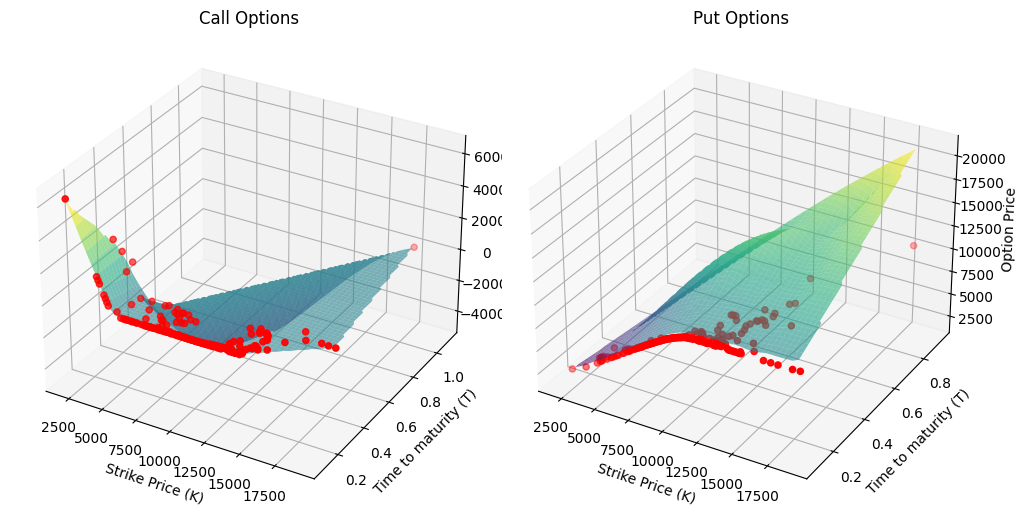

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Read the data
file_path = 'M76_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.set_zlabel('Option Price')

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.set_zlabel('Option Price')

plt.tight_layout()
plt.show()


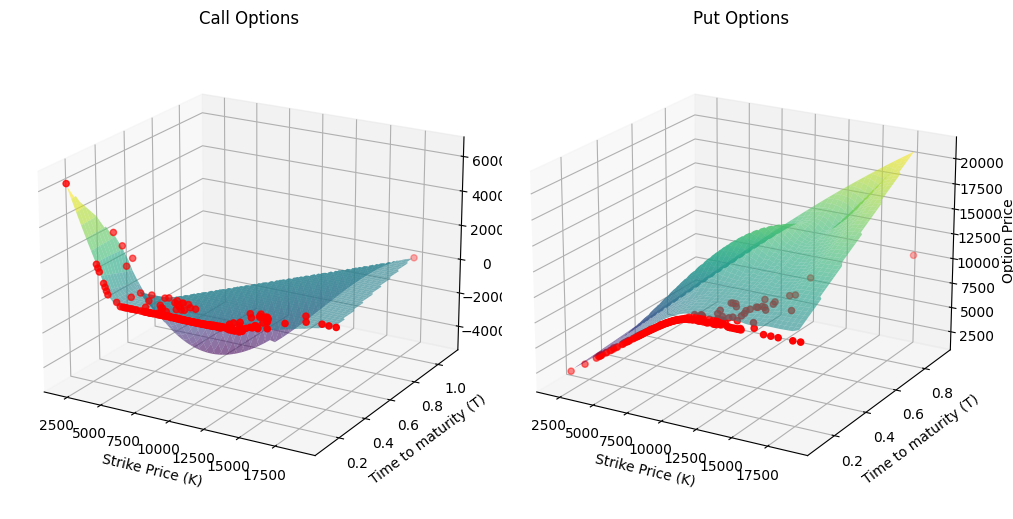

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Read the data
file_path = 'M76_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.zaxis.set_rotate_label(False)  # Disable automatic rotation
ax1.set_zlabel('Option Price', rotation=90)
ax1.view_init(20, -60)  # Adjust the viewing angle for better visualization

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.zaxis.set_rotate_label(False)  # Disable automatic rotation
ax2.set_zlabel('Option Price', rotation=90)
ax2.view_init(20, -60)  # Adjust the viewing angle for better visualization

plt.tight_layout()
plt.show()


In [25]:
import pandas as pd

# Read the data
file_path = 'M76_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Extract relevant columns
result = options_data[['PUTCALLIND', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'OUTSIDE_THRESHOLD']]

print(result)

# Export the DataFrame to a CSV file
result.to_csv('M76_SLSQP_with_errors.csv', index=False)


    PUTCALLIND  IMP_VOLT  PERCENTAGE_ERROR  OUTSIDE_THRESHOLD
1         CALL     23.23               NaN              False
2         CALL     23.23               NaN              False
3         CALL     23.25               inf               True
4         CALL     23.26               inf               True
5         CALL     23.32               inf               True
..         ...       ...               ...                ...
373       CALL    115.42      2.601291e-05              False
374       CALL    118.17      9.112146e-07              False
375       CALL    130.77      1.826734e-06              False
376       PUT     150.50      7.084663e+00               True
377       CALL    203.25      1.552314e+00              False

[377 rows x 4 columns]


In [26]:
import numpy as np
import pandas as pd

# Read the data
file_path = 'M76_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Replace 'inf' percentage error with None for CALL options
options_data.loc[(options_data['PUTCALLIND'] == 'CALL') & (options_data['PERCENTAGE_ERROR'] == np.inf), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Count the number of 'CALL' and 'PUT' options within the threshold
num_calls_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'CALL') & (options_data['OUTSIDE_THRESHOLD'] == False)])
num_puts_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'PUT ') & (options_data['OUTSIDE_THRESHOLD'] == False)])

print(f"Number of CALL options within threshold: {num_calls_within_threshold}")
print(f"Number of PUT options within threshold: {num_puts_within_threshold}")


Number of CALL options within threshold: 185
Number of PUT options within threshold: 38


In [27]:
import pandas as pd
import plotly.express as px

# Read the data
file_path = 'M76_SLSQP_options_numba_2.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Correct infinite percentage errors due to division by zero
options_data.loc[options_data['PERCENTAGE_ERROR'] == float('inf'), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Create a new column combining option type and threshold status
options_data['OPTION_STATUS'] = options_data.apply(lambda row: row['PUTCALLIND'].strip() + (' Outside' if row['OUTSIDE_THRESHOLD'] else ' Inside'), axis=1)

# Extract relevant columns
result = options_data[['OPTION_STATUS', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'MODEL_PRICE']]

# Create a scatter plot with facets
fig = px.scatter(result,
                 x='MODEL_PRICE',
                 y='IMP_VOLT',
                 color='PERCENTAGE_ERROR',
                 facet_col='OPTION_STATUS',
                 title='Option Prices vs. Implied Volatility',
                 labels={'MODEL_PRICE': 'Option Price', 'IMP_VOLT': 'Implied Volatility', 'OPTION_STATUS': 'Option Type & Status'},
                 color_continuous_scale='viridis',
                 hover_data=['OPTION_STATUS', 'PERCENTAGE_ERROR'])

# Modify the marker aesthetics
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

# Show the plot
fig.show()
